In [36]:
import json
from matplotlib import pyplot
import seaborn as sns
import pathlib
import pandas as pd
import seaborn as sns

In [37]:
sns.set_theme()

In [38]:
BENCH_RES = pathlib.Path("../bench-res.json")

if not BENCH_RES.is_file():
    raise ValueError(f"Cannot find input {BENCH_RES}")

In [39]:
def load_json():
    with BENCH_RES.open() as f:
        return json.loads(f.read())

bench_data = load_json()

In [40]:
bench_data.keys()

dict_keys(['machine_info', 'commit_info', 'benchmarks', 'datetime', 'version'])

In [41]:
bench_data["benchmarks"][0]["stats"]

{'min': 0.10807583999985582,
 'max': 0.1180534339996484,
 'mean': 0.11061538422220313,
 'stddev': 0.002987717604110428,
 'rounds': 9,
 'median': 0.11059227499981716,
 'iqr': 0.0019685389999040126,
 'q1': 0.10878381975021512,
 'q3': 0.11075235875011913,
 'iqr_outliers': 1,
 'stddev_outliers': 1,
 'outliers': '1;1',
 'ld15iqr': 0.10807583999985582,
 'hd15iqr': 0.1180534339996484,
 'ops': 9.040333829073989,
 'total': 0.9955384579998281,
 'data': [0.1180534339996484,
  0.1107496610002272,
  0.11074902000018483,
  0.11059227499981716,
  0.1107604519997949,
  0.10807583999985582,
  0.10888576400020611,
  0.10847798700024214,
  0.10919402499985154],
 'iterations': 1}

In [42]:
# CHECK THAT THE STANDARD DESIVATIONS ARE VERY VERY LOW.
def get_stdevs():
    for bench in bench_data["benchmarks"]:
        yield bench["stats"]["stddev"]
list(get_stdevs())

[0.002987717604110428,
 0.0012909883566628224,
 0.01377333250863117,
 0.0010390322314055415,
 0.003477987729600917,
 0.003499611508056031,
 0.0021209697683207446,
 0.001072544918699351,
 0.0005058609392844319,
 0.05794823702139052]

In [43]:
def get_names():
    for bench in bench_data["benchmarks"]:
        yield (
            bench["name"]
            .removeprefix("test_")
            .removesuffix("[100000]")
            .removesuffix("[100000]")
        )
list(get_names())

['serialize_json',
 'deserialize_json',
 'serialize_pickle',
 'deserialize_pickle',
 'serialize_msgpack',
 'deserialize_msgpack',
 'serialize_pb',
 'deserialize_pb',
 'serialize_pyrobuf',
 'deserialize_pyrobuf']

In [44]:
def get_means():
    for bench in bench_data["benchmarks"]:
        yield bench["stats"]["mean"]
list(get_means())

[0.11061538422220313,
 0.1359939523750313,
 0.09732019708330124,
 0.08574443025008804,
 0.05696188361106477,
 0.08937633058330145,
 0.024726555176464576,
 0.006163690673673428,
 0.07047561676913225,
 0.09401437138460376]

In [45]:
df = (
        pd.DataFrame({
        "name": get_names(),
        "std": get_stdevs(),
        "mean": get_means(),
    })
    .assign(
        serialize=lambda df_: ~df_["name"].str.contains("deserialize"),
        name=lambda df_: df_["name"].str.removeprefix("deserialize_").str.removeprefix("serialize_"),
    )
    .assign(
        name=lambda df_: df_["name"].mask(lambda s_: s_ == "pb", "protobuf")
    )
    .sort_values("mean")
)
df

,name,std,mean,serialize
7,protobuf,0.001073,0.006164,False
6,protobuf,0.002121,0.024727,True
4,msgpack,0.003478,0.056962,True
8,pyrobuf,0.000506,0.070476,True
3,pickle,0.001039,0.085744,False
5,msgpack,0.003500,0.089376,False
9,pyrobuf,0.057948,0.094014,False
2,pickle,0.013773,0.097320,True
0,json,0.002988,0.110615,True
1,json,0.001291,0.135994,False


In [46]:
df.pivot(index="name", columns="serialize", values="mean").index.rename("type")

Index(['json', 'msgpack', 'pickle', 'protobuf', 'pyrobuf'], dtype='object', name='type')

<Axes: title={'center': 'Mean serialization/deserialization time for 100k messages'}, xlabel='name'>

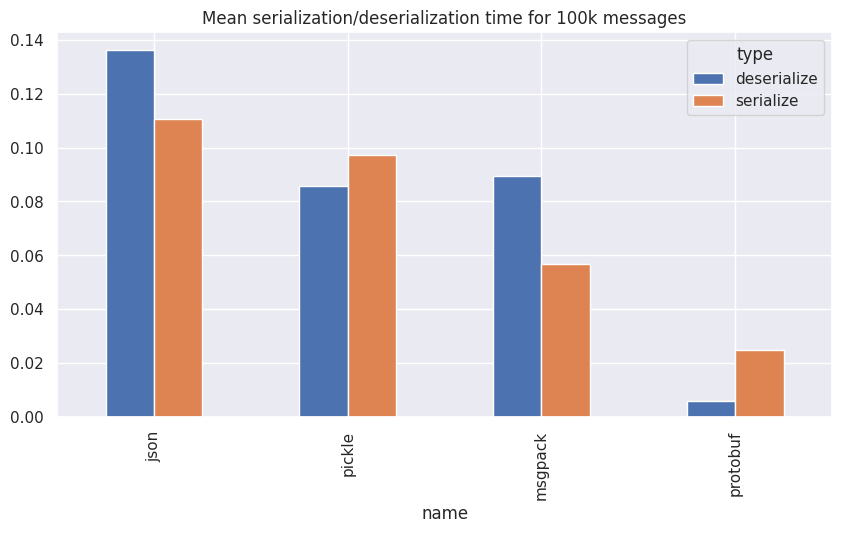

In [47]:
def show_plot_res():
    return (
        df
        .loc[lambda df_: df_["name"] != "pyrobuf"]
        .pivot(index="name", columns="serialize", values="mean")
        .rename(columns={True: "serialize", False: "deserialize"})
        .rename_axis(columns={"serialize": "type"})
        .sort_values("serialize", ascending=False)
        .plot.bar(
            title="Mean serialization/deserialization time for 100k messages",
            figsize=(10, 5),
        )
    )

show_plot_res()

In [48]:
print(
    df
    .loc[lambda df_: df_["name"] != "pyrobuf"]
    .pivot(index="name", columns="serialize", values="mean")
    .rename(columns={True: "serialize", False: "deserialize"})
    .to_markdown()
)

| name     |   deserialize |   serialize |
|:---------|--------------:|------------:|
| json     |    0.135994   |   0.110615  |
| msgpack  |    0.0893763  |   0.0569619 |
| pickle   |    0.0857444  |   0.0973202 |
| protobuf |    0.00616369 |   0.0247266 |
